# AI in Healthcare - Assignment 1: MIMIC-III Natural Language Processing

### Connect to MIMIC-III Through Google BigQuery

In [1]:
# Auth is meant for Google Colab. May have to set up dataset locally or create your own Big Query dataset
# Standard Jupyter Notebook may have a different setup process
from google.colab import auth
from google.cloud import bigquery
bq_client = bigquery.Client(project = "project-id")
auth.authenticate_user()


In [2]:
%%capture
# Import libraries
!pip install spacy==3.7.5
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from spacy import displacy
import random
import re
import spacy
from tqdm import tqdm

pretrained_model = api.load("glove-wiki-gigaword-50")
nlp_spacy = spacy.load('en_core_web_sm')


### Preprocess Data

In [3]:
# Query Nueromyelitis Optica Spectrum Disorder medical notes and keep unique texts
ms_notes_df = bq_client.query('''
SELECT ne.subject_id, ne.chartdate, ne.category, ne.text, d.icd9_code, icd.long_title AS diagnosis
FROM `physionet-data.mimiciii_notes.noteevents` AS ne
JOIN `physionet-data.mimiciii_clinical.diagnoses_icd` AS d ON ne.subject_id = d.subject_id
JOIN `physionet-data.mimiciii_clinical.d_icd_diagnoses` AS icd ON d.icd9_code = icd.icd9_code
WHERE d.icd9_code = '3410'
ORDER BY ne.subject_id, ne.chartdate;
''').to_dataframe()

ms_notes_df = ms_notes_df.drop_duplicates(subset=['text'], keep='first')


In [4]:
# Clean the text
nmosd_notes = []
for _, row in ms_notes_df.iterrows():
    text = row['text']
    text = text.strip()
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\[\*\*.*?\*\*\]', '', text)
    text = re.sub(r'[^a-zA-Z0-9,.!?% ]', '', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r'\s+([.,!?%])', r'\1', text)
    nmosd_notes.append(text)


### Part 1 - NLP of NMOSD patient notes using Spacy

In [5]:
# Entity visualization
for i in range(3):
    doc = nlp_spacy(nmosd_notes[i])
    displacy.render(doc, style='ent', jupyter=True)
    print("---------------------------")


---------------------------


---------------------------


---------------------------


In [6]:
# Create corpus
corpus_spacy = []
for row in tqdm(range(len(nmosd_notes))):
  str_tokens = []
  tokens = nlp_spacy(nmosd_notes[row]).ents
  for i in range(0, len(tokens)):
    str_tokens.append(tokens[i].text)
  corpus_spacy.append(list(str_tokens))


100%|██████████| 172/172 [00:24<00:00,  7.05it/s]


In [7]:
# Create W2V model
model_spacy = Word2Vec(corpus_spacy, min_count=1)


In [8]:
# Show W2V for 'diverticulitis'
model_spacy.wv['diverticulitis']


array([-2.2069763e-03,  3.1562871e-03,  8.8240867e-03, -9.2775878e-03,
        8.3783027e-03,  3.0736034e-04,  8.6124009e-03,  4.1814148e-03,
       -5.8026100e-03, -5.8618265e-05,  9.3545662e-03,  5.3341882e-03,
        7.9646967e-03,  9.7369244e-03,  2.2322494e-03, -1.9185887e-04,
       -2.1456373e-03,  7.9063070e-04,  5.0655100e-03, -8.1803100e-03,
        3.2964419e-03,  6.9003613e-03,  4.8365938e-03,  4.9708998e-03,
        2.7084881e-03, -9.0624178e-03, -3.6999600e-03,  7.5932681e-03,
        5.1846472e-03, -5.3115557e-03,  1.4378357e-03,  2.3279563e-03,
       -4.8689158e-03, -4.6908404e-03,  1.1710131e-03,  3.8234696e-03,
        9.5103923e-03, -6.8599689e-03, -5.3088400e-03,  5.2709496e-03,
        8.8702748e-03,  9.3907611e-03,  6.0181660e-03,  1.6135850e-03,
        5.2177846e-03, -7.7261948e-03, -5.9987400e-03,  1.1794148e-04,
        3.1815395e-03,  4.2114435e-03,  7.3190173e-03,  2.7855113e-03,
        9.8167490e-03,  2.4591100e-03, -1.4726407e-03, -7.6487820e-05,
      

In [9]:
# Find most similiar words to 'diverticulitis'
model_spacy.wv.similar_by_word('diverticulitis')


[('PO BID 11', 0.337181955575943),
 ('1500', 0.3282739520072937),
 ('20 99%RA', 0.2829912602901459),
 ('30cchr', 0.28291019797325134),
 ('Intrathecal', 0.28091850876808167),
 ('225', 0.2789475619792938),
 ('BILLING DIAGNOSIS ICU CARE GLYCEMIC CONTROL RISS', 0.2738442122936249),
 ('Results Labs', 0.24722597002983093),
 ('0641PM', 0.24681124091148376),
 ('Home', 0.2464621365070343)]

In [10]:
# Function to create TSNE plot
def tsne_plot(model, words, preTrained=False):
    labels = []
    tokens = []

    for word in words:
        if preTrained == True:
            if word in model:
                tokens.append(model[word] if preTrained else model.wv[word])
                labels.append(word)
        else:
            tokens.append(model[word] if preTrained else model.wv[word])
            labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', max_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x, y = zip(*new_values)

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()


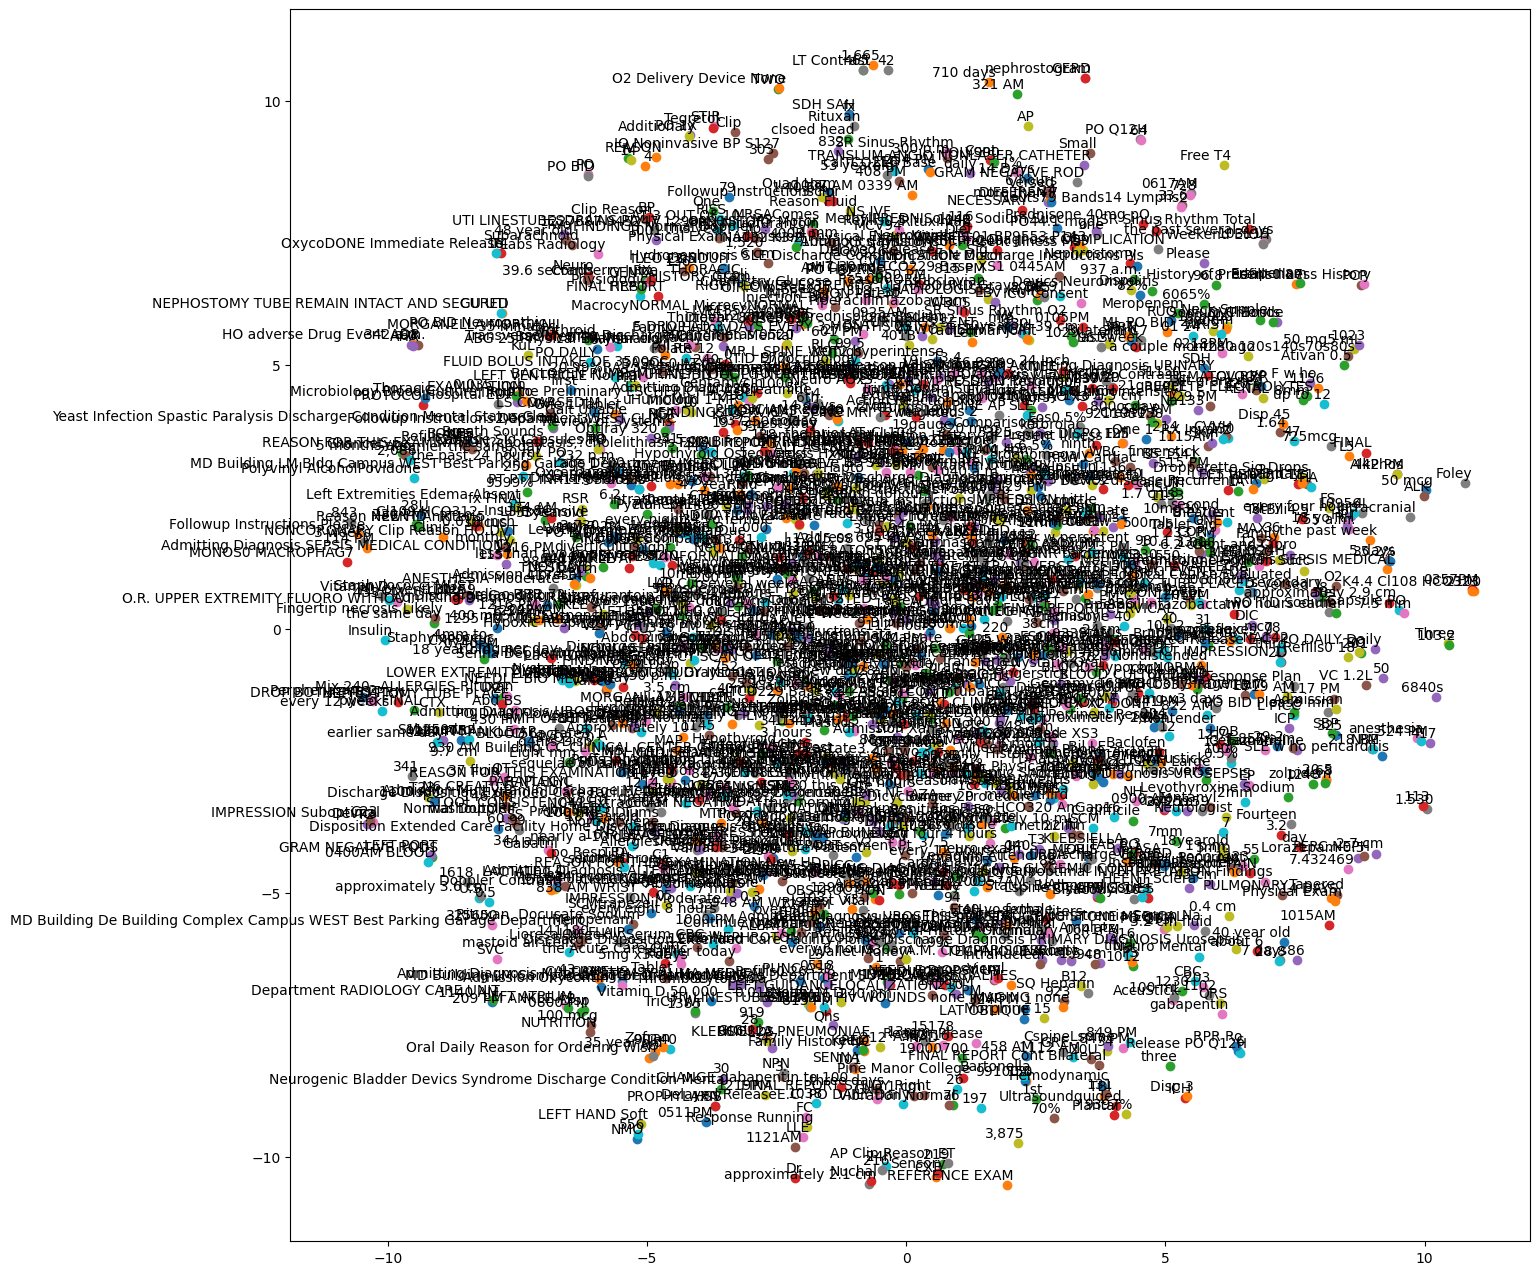

In [11]:
# Plot TSNE
vocabs = model_spacy.wv.key_to_index.keys()
words = np.array(list(vocabs))
tsne_plot(model_spacy, words)


In [12]:
# Create corpus for pretrained model
corpus_in_pretrained_model = []
for word in vocabs:
  if word in pretrained_model:
    corpus_in_pretrained_model.append(word)


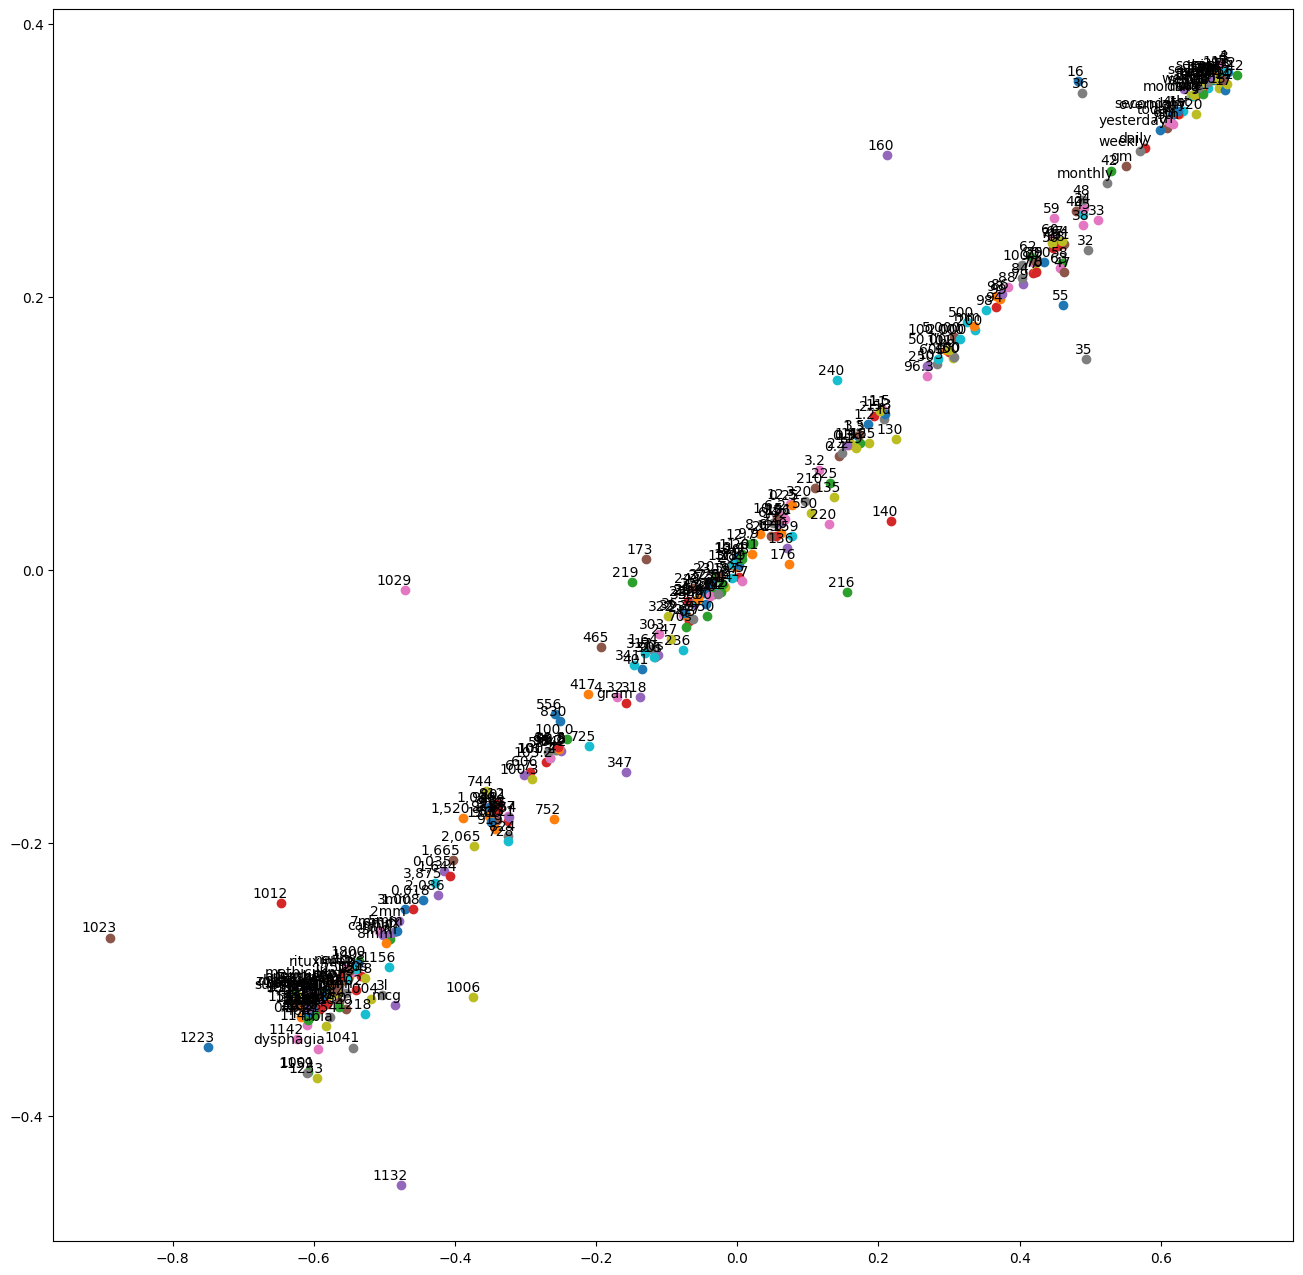

In [13]:
# Plot TSNE using pretrained model
tsne_plot(pretrained_model, corpus_in_pretrained_model, preTrained=True)


### Part 2 - NLP of NMOSD patient notes using SciSpacy

In [16]:
%%capture
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_md-0.5.4.tar.gz
import scispacy
nlp_scispacy = spacy.load('en_core_sci_md')


In [17]:
# Entity visualization
for i in range(3):
    doc = nlp_scispacy(nmosd_notes[i])
    displacy.render(doc, style='ent', jupyter=True)
    print("---------------------------")


---------------------------


---------------------------


---------------------------


In [18]:
# Create corpus
corpus_scispacy = []
for row in tqdm(range(len(nmosd_notes))):
  str_tokens = []
  tokens = nlp_scispacy(nmosd_notes[row]).ents
  for i in range(0, len(tokens)):
    str_tokens.append(tokens[i].text)
  corpus_scispacy.append(list(str_tokens))


100%|██████████| 172/172 [00:28<00:00,  6.04it/s]


In [19]:
# Create W2V model
model_scispacy = Word2Vec(corpus_scispacy, min_count=1)


In [20]:
# Show W2V for 'diverticulitis'
model_scispacy.wv['diverticulitis']


array([-7.0170243e-04, -4.9348907e-03, -6.4459094e-03,  1.0087876e-02,
       -8.0410512e-03,  9.0745613e-03, -9.6872151e-03,  4.5930353e-04,
       -3.9709806e-03,  5.4174215e-03,  8.8455575e-03,  3.6783732e-04,
       -7.2651487e-03, -7.5547551e-03, -2.3223506e-04,  5.6831795e-03,
       -7.0611173e-03, -1.5227579e-03,  2.6500411e-03,  3.8315416e-03,
        4.6273521e-03, -6.4738663e-03, -6.6725356e-03, -8.6745219e-03,
       -9.5049599e-03,  4.6640079e-04,  4.9921954e-03,  5.1155253e-03,
       -8.6483825e-03, -4.1282843e-03,  4.5276475e-03,  7.9027005e-03,
        5.1184972e-03, -1.3470954e-03, -3.5143544e-03, -9.2019998e-03,
        5.6368136e-03,  5.8939913e-03,  8.9649195e-03,  5.9732059e-03,
       -1.0734015e-03, -7.5223846e-03,  4.5159226e-03, -8.3971135e-03,
        3.8024560e-03,  3.5979334e-05, -3.9827162e-03,  3.1726509e-03,
        5.2741994e-03,  9.6654259e-03, -6.7856698e-03,  2.1551482e-03,
       -3.1155529e-03, -2.0836447e-03,  1.4447230e-03,  3.4121235e-03,
      

In [21]:
# Find most similiar words to 'diverticulitis'
model_scispacy.wv.similar_by_word('diverticulitis')


[('Neuro checks', 0.3382490277290344),
 ('sleepy', 0.3282153606414795),
 ('bony erosions', 0.3262634873390198),
 ('good effect', 0.32143890857696533),
 ('buttress plate screws', 0.3159286379814148),
 ('Eos0.7 Baso0.2 0400AM BLOOD Neuts76 Bands16 Lymphs3 Monos3 Eos0',
  0.3116353452205658),
 ('cerclage', 0.3069118559360504),
 ('schistosomiasis', 0.30084967613220215),
 ('rhonchi', 0.29121458530426025),
 ('fibular distal shaft fracture', 0.2911006510257721)]

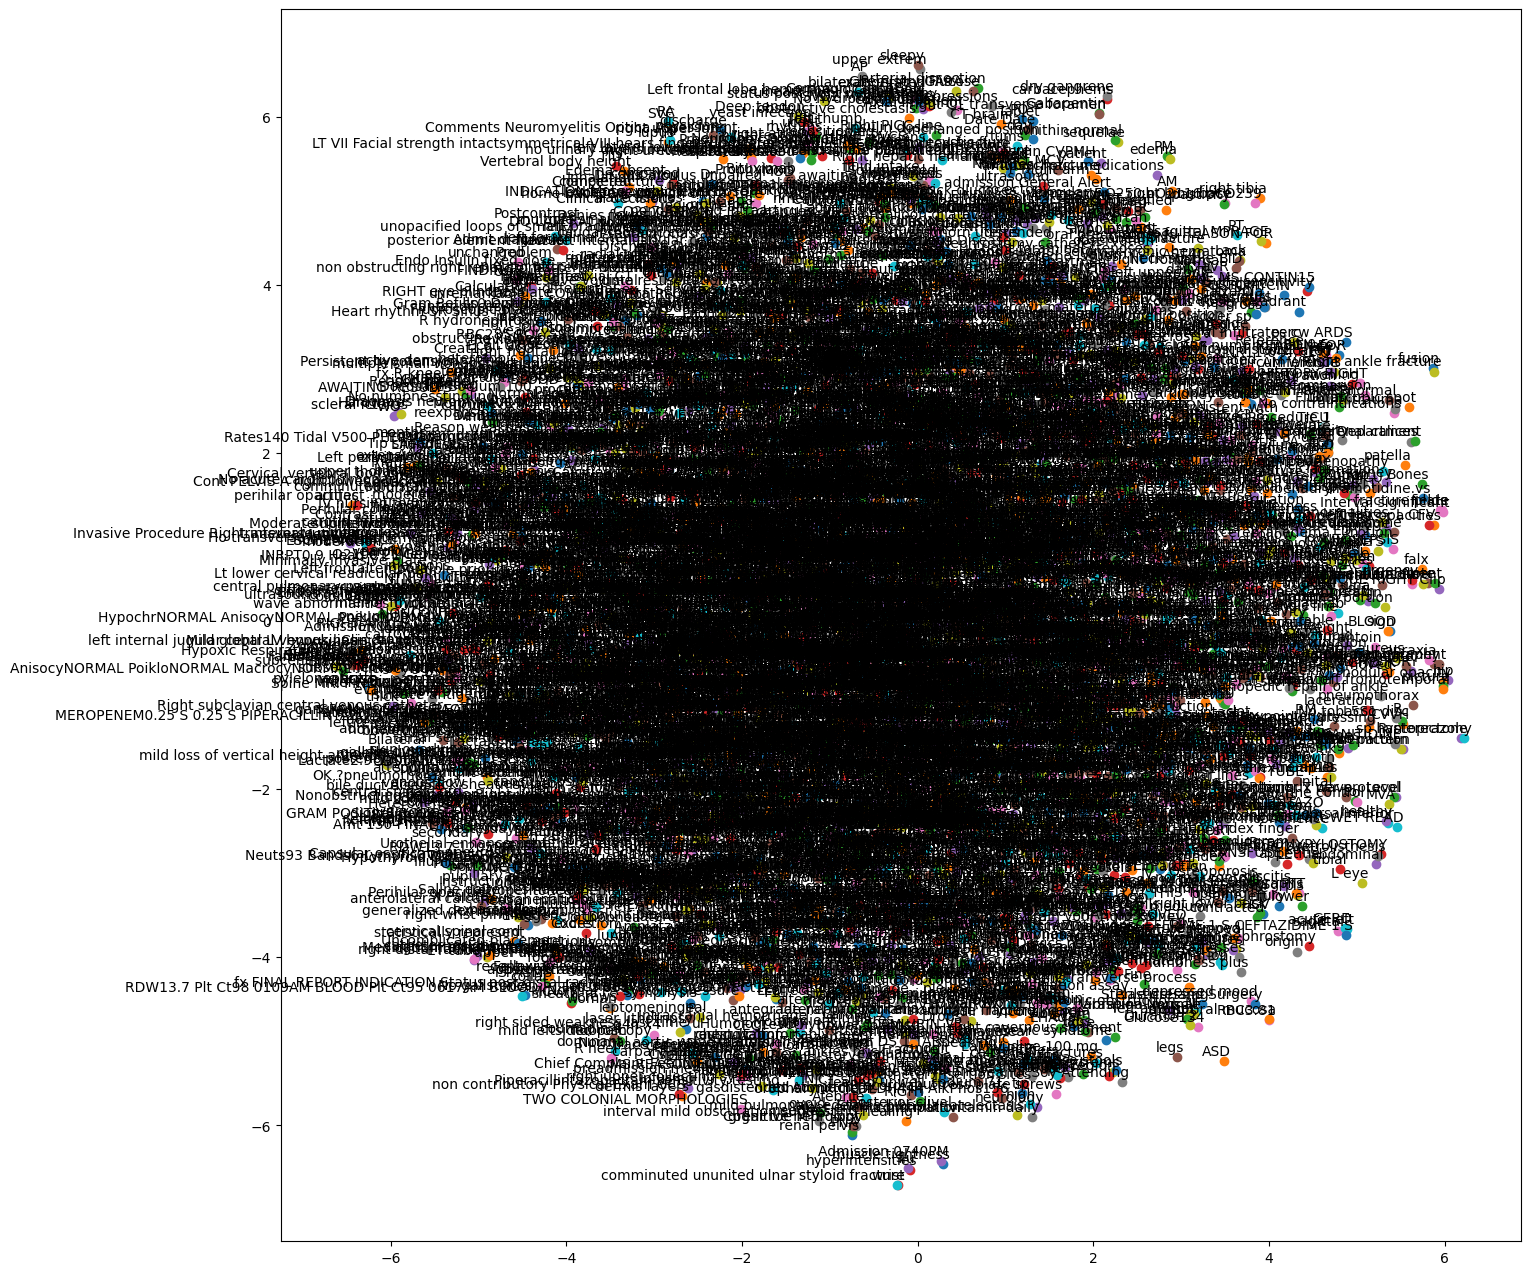

In [22]:
# Plot TSNE
vocabs = model_scispacy.wv.key_to_index.keys()
words = np.array(list(vocabs))
tsne_plot(model_scispacy, words)


In [23]:
# Create corpus for pretrained model
corpus_in_pretrained_model = []
for word in vocabs:
  if word in pretrained_model:
    corpus_in_pretrained_model.append(word)


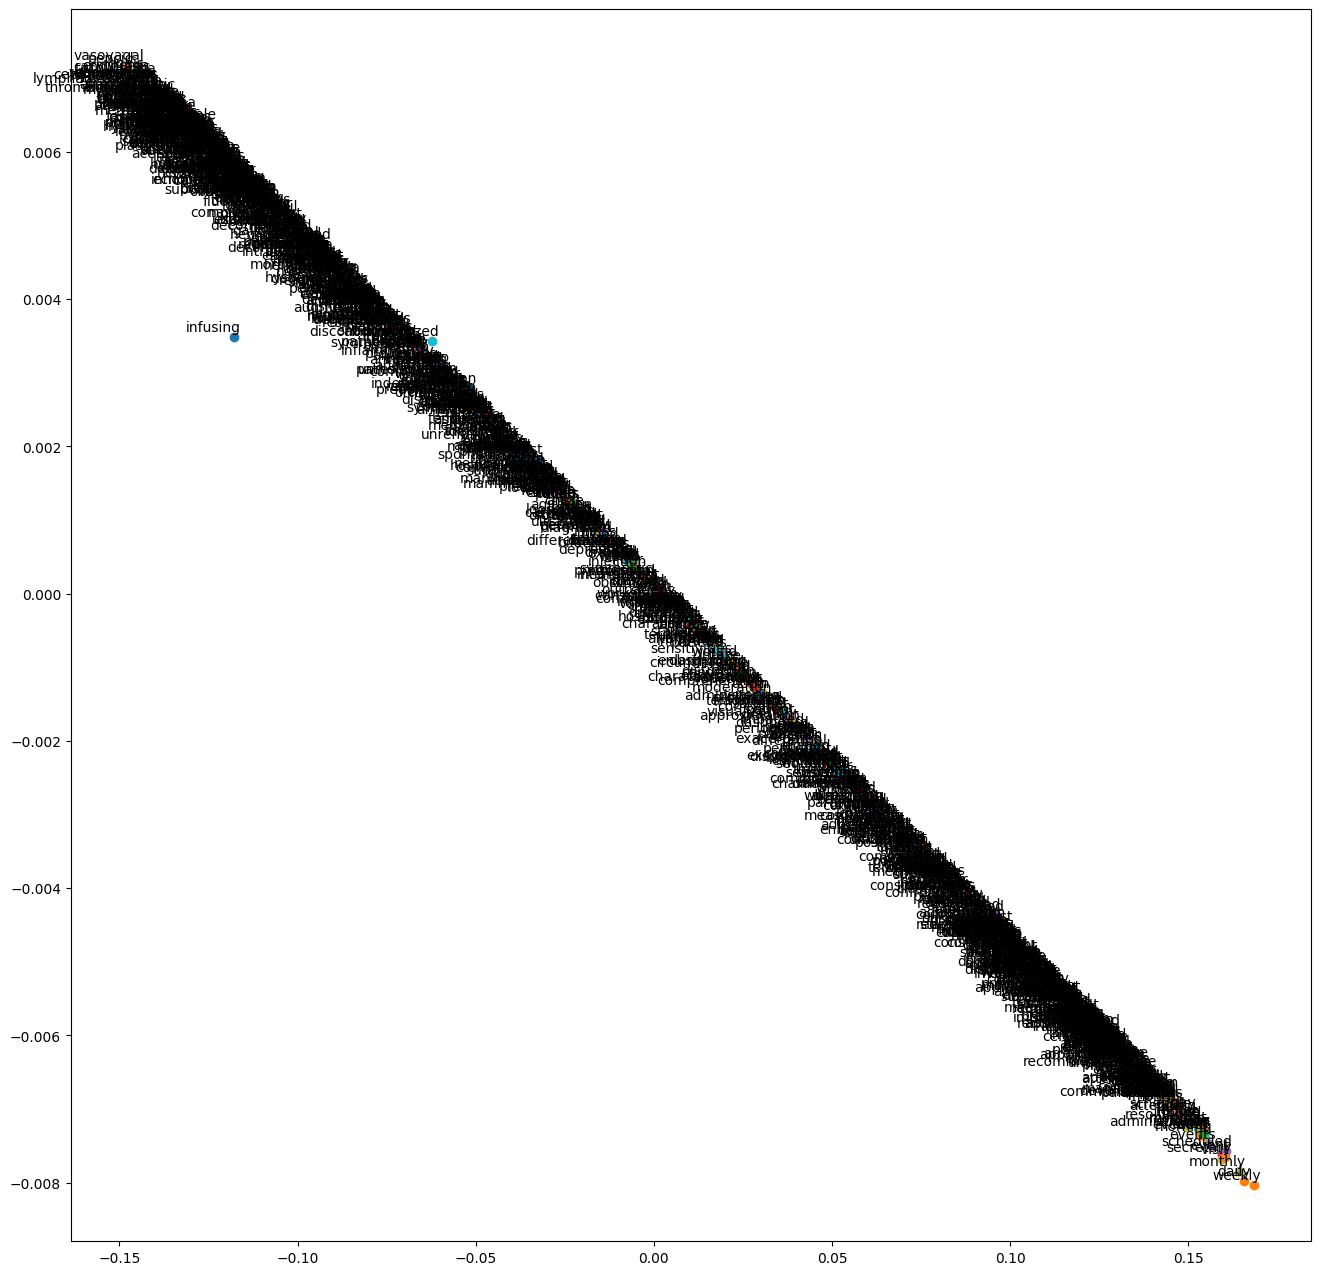

In [24]:
# Plot TSNE using pretrained model
tsne_plot(pretrained_model, corpus_in_pretrained_model, preTrained=True)


### Part 3 - NLP of NMOSD patient notes using BlueBert

In [25]:
%%capture
!pip install torch transformers sentencepiece
from transformers import AutoTokenizer, AutoModel, pipeline
import torch
tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12")
model = AutoModel.from_pretrained("bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)
nlp_bluebert = spacy.blank("en")


In [26]:
# Create corpus
corpus_bluebert = []
for text in tqdm(nmosd_notes):
    tokens = tokenizer.tokenize(text)
    corpus_bluebert.append(tokens)


 30%|██▉       | 51/172 [00:00<00:00, 507.61it/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 172/172 [00:00<00:00, 291.96it/s]


In [27]:
# Get embeddings
def get_bluebert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

bluebert_embeddings = np.array([get_bluebert_embeddings(text) for text in nmosd_notes])


In [28]:
# Create TSNE plot
def tsne_plot_bert(embeddings, labels):
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', max_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(embeddings)

    x, y = zip(*new_values)

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()


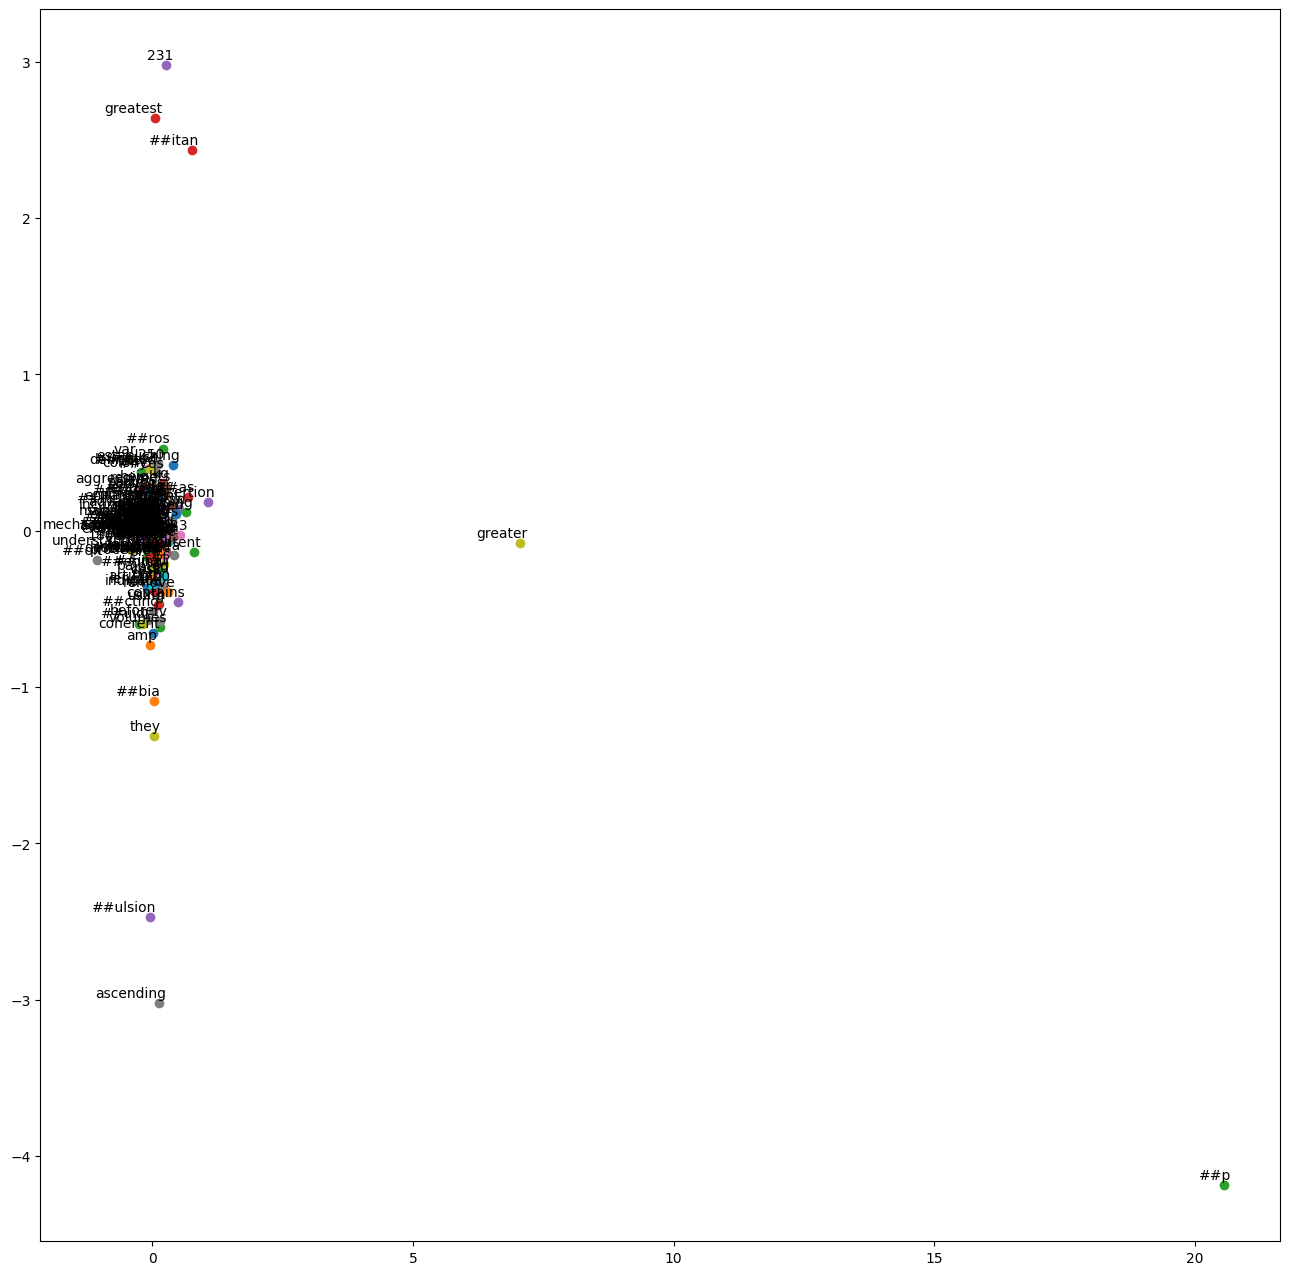

In [29]:
# Plot TSNE
words = list(set([word for tokens in corpus_bluebert for word in tokens]))
tsne_plot_bert(bluebert_embeddings, words)


In [31]:
# Create corpus for pretrained model.
corpus_pretrained = [word for word in words if word in pretrained_model]
glove_embeddings = np.array([pretrained_model[word] for word in corpus_pretrained])


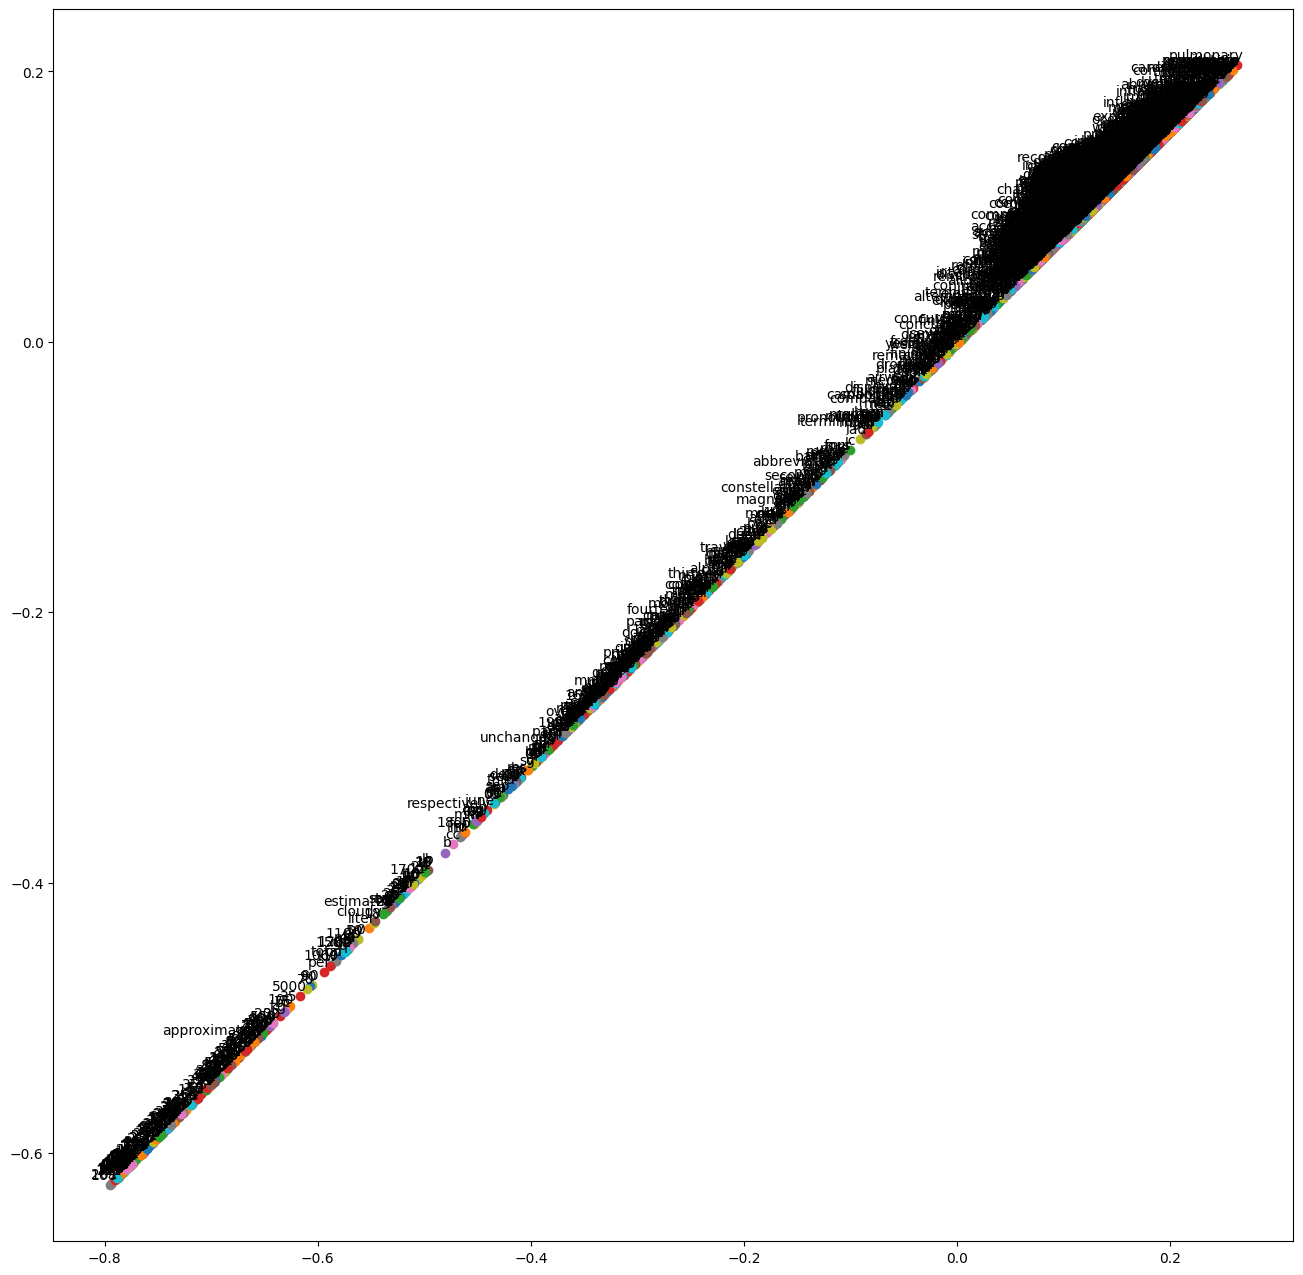

In [32]:
# Plot TSNE using pretrained model
tsne_plot_bert(glove_embeddings, corpus_pretrained)
